In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to determine the detailed season for a given date
def get_detailed_season(date):
    month = date.month
    if month == 3 or month == 4:
        return 'Early Spring'
    elif month == 5:
        return 'Late Spring'
    elif month == 6 or month == 7:
        return 'Early Summer'
    elif month == 8:
        return 'Late Summer'
    elif month == 9 or month == 10:
        return 'Early Fall'
    elif month == 11:
        return 'Late Fall'
    elif month == 12 or month == 1:
        return 'Early Winter'
    elif month == 2:
        return 'Late Winter'
    
# Load cleaned and clean data
cleaned_airbnb_data = pd.read_csv('Resources/cleaned_airbnb_listings_usa.csv')
cleaned_airbnb_data = cleaned_airbnb_data.drop_duplicates(subset=['id', 'host_id'])
cleaned_airbnb_data['last_review'] = pd.to_datetime(cleaned_airbnb_data['last_review'])
cleaned_airbnb_data['detailed_season'] = cleaned_airbnb_data['last_review'].apply(get_detailed_season)

# Define the correct order for detailed seasons
season_order = [
    'Early Spring', 'Late Spring', 'Early Summer', 'Late Summer',
    'Early Fall', 'Late Fall', 'Early Winter', 'Late Winter'
]

# Convert 'detailed_season' to a categorical type with the correct order
cleaned_airbnb_data['detailed_season'] = pd.Categorical(
    cleaned_airbnb_data['detailed_season'], categories=season_order, ordered=True
)
# Display the DataFrame with the new 'detailed_season' column and removed duplicates
print(cleaned_airbnb_data.head())


         id                                               name    host_id  \
0  29819757   Hotel Perks - Private Bedroom | Private Bathroom   57387860   
1      8357  The Mushroom Dome Retreat & LAND of Paradise S...      24281   
2  42409434                               The Burlington Hotel  229716119   
3  35158303                     SAHARA Las Vegas, Marra 1 King  263748930   
4  44799007             Sonder Battery Park | Studio Apartment  219517861   

   neighbourhood_group                                neighbourhood  latitude  \
0                  NaN                              Near North Side  41.89230   
1                  NaN                         Unincorporated Areas  37.00939   
2  City of Los Angeles                                     Westlake  34.05981   
3                  NaN                         Unincorporated Areas  36.14215   
4                  NaN  Ward F (councilmember Jermaine D. Robinson)  40.70617   

   longitude        room_type  price  minimum_nigh

In [2]:
# Group by 'detailed_season' and calculate average metrics
seasonal_data = cleaned_airbnb_data.groupby('detailed_season').agg({
    'price': 'mean',  # Average nightly rental cost
    'number_of_reviews': 'mean',  # Average number of reviews
    'reviews_per_month': 'mean',  # Average reviews per month
    'availability_365': 'mean'  # Average availability over 365 days
}).reset_index()

# Rename columns for clarity
seasonal_data.columns = ['Detailed Season', 'Average Price', 'Average Number of Reviews', 'Average Reviews per Month', 'Average Availability']

# Display the aggregated data
print("Seasonal Data Aggregation:")
print(seasonal_data)

Seasonal Data Aggregation:
  Detailed Season  Average Price  Average Number of Reviews  \
0    Early Spring     156.424615                 179.863590   
1     Late Spring     190.421227                 176.767828   
2    Early Summer     208.169912                 173.487973   
3     Late Summer     184.124698                 195.739615   
4      Early Fall     172.203996                 218.188025   
5       Late Fall     147.051661                 181.955720   
6    Early Winter     171.962376                 177.213861   
7     Late Winter     152.508772                 165.740351   

   Average Reviews per Month  Average Availability  
0                   2.430421            112.880000  
1                   2.566103            146.847430  
2                   2.536739            165.083238  
3                   3.411451            177.960626  
4                   4.248292            180.114055  
5                   2.420443            120.439114  
6                   2.394931      

C:\Users\Bryan Hamilton-Brown\AppData\Local\Temp\ipykernel_5524\1636977113.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_data = cleaned_airbnb_data.groupby('detailed_season').agg({


In [3]:
# Define colors for each detailed season
season_colors = {
    'Early Spring': 'lightgreen',
    'Late Spring': 'forestgreen',
    'Early Summer': 'skyblue',
    'Late Summer': 'deepskyblue',
    'Early Fall': 'orange',
    'Late Fall': 'darkorange',
    'Early Winter': 'lightgrey',
    'Late Winter': 'darkgrey'
}

# Plot settings
def plot_seasonal_data(seasonal_data, metric, ylabel, title, ax2_label='Average Price (Nightly Rental Cost)'):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.bar(seasonal_data['Detailed Season'], seasonal_data[metric], color=[season_colors[season] for season in seasonal_data['Detailed Season']], edgecolor='black')
    ax1.set_xlabel('Detailed Season', fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_title(title, fontsize=16)
    
    ax2 = ax1.twinx()
    ax2.plot(seasonal_data['Detailed Season'], seasonal_data['Average Price'], color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8)
    ax2.set_ylabel(ax2_label, fontsize=14, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

# Set plot style
plt.style.use('ggplot')

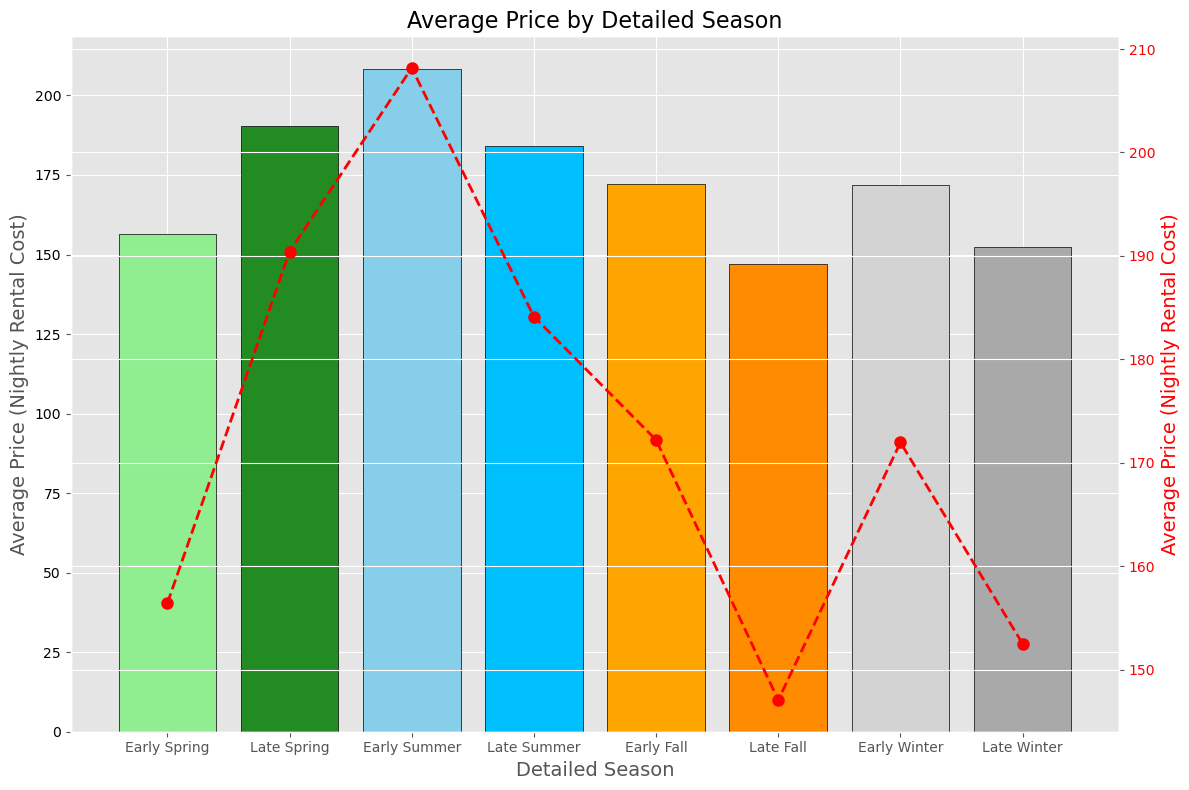

In [4]:
# Plot Average Price by Detailed Season
plot_seasonal_data(seasonal_data, 'Average Price', 'Average Price (Nightly Rental Cost)', 'Average Price by Detailed Season')

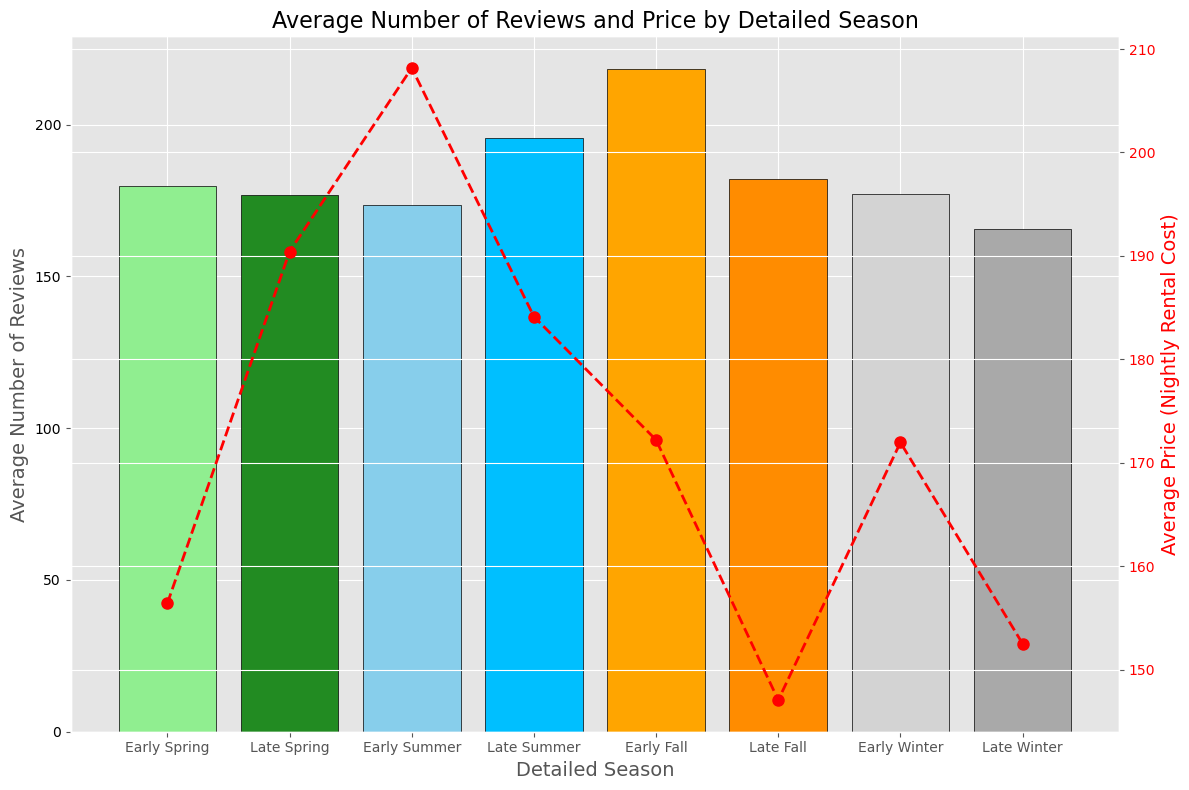

In [5]:
# Plot Average Number of Reviews by Detailed Season with Price
plot_seasonal_data(seasonal_data, 'Average Number of Reviews', 'Average Number of Reviews', 'Average Number of Reviews and Price by Detailed Season')

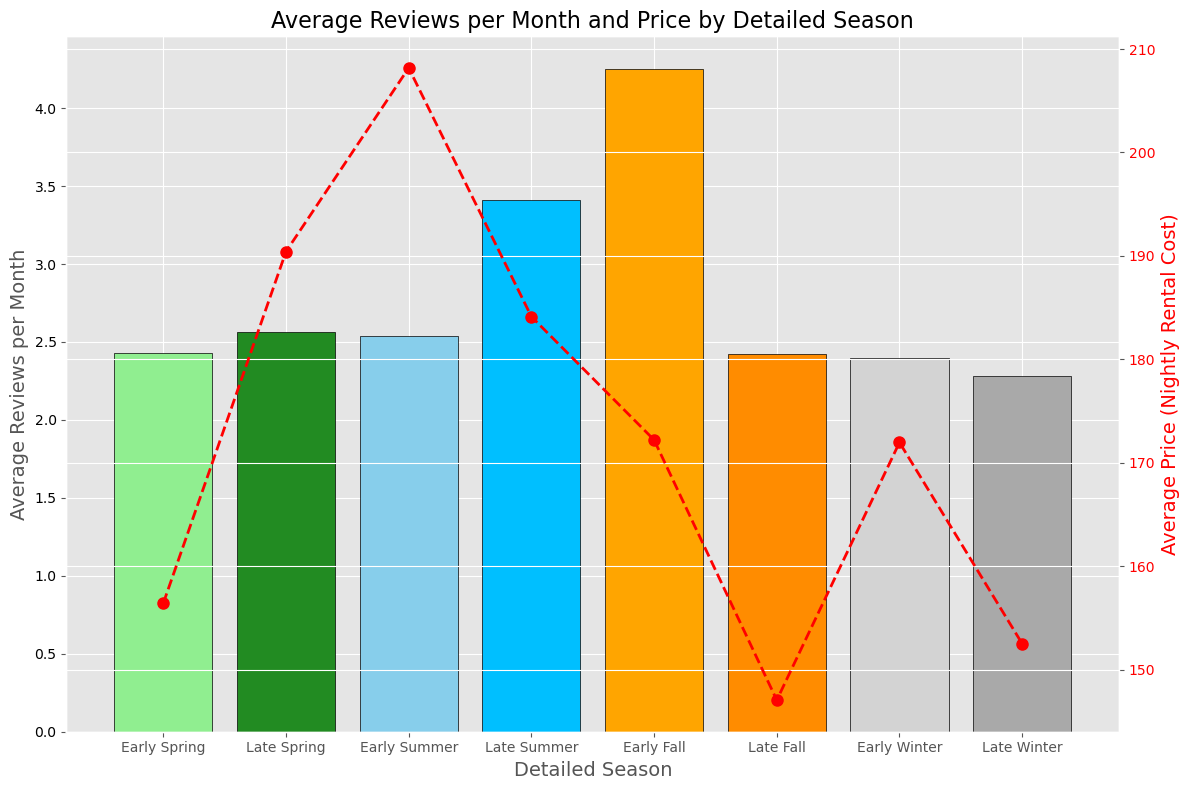

In [6]:
# Plot Average Reviews per Month by Detailed Season with Price
plot_seasonal_data(seasonal_data, 'Average Reviews per Month', 'Average Reviews per Month', 'Average Reviews per Month and Price by Detailed Season')

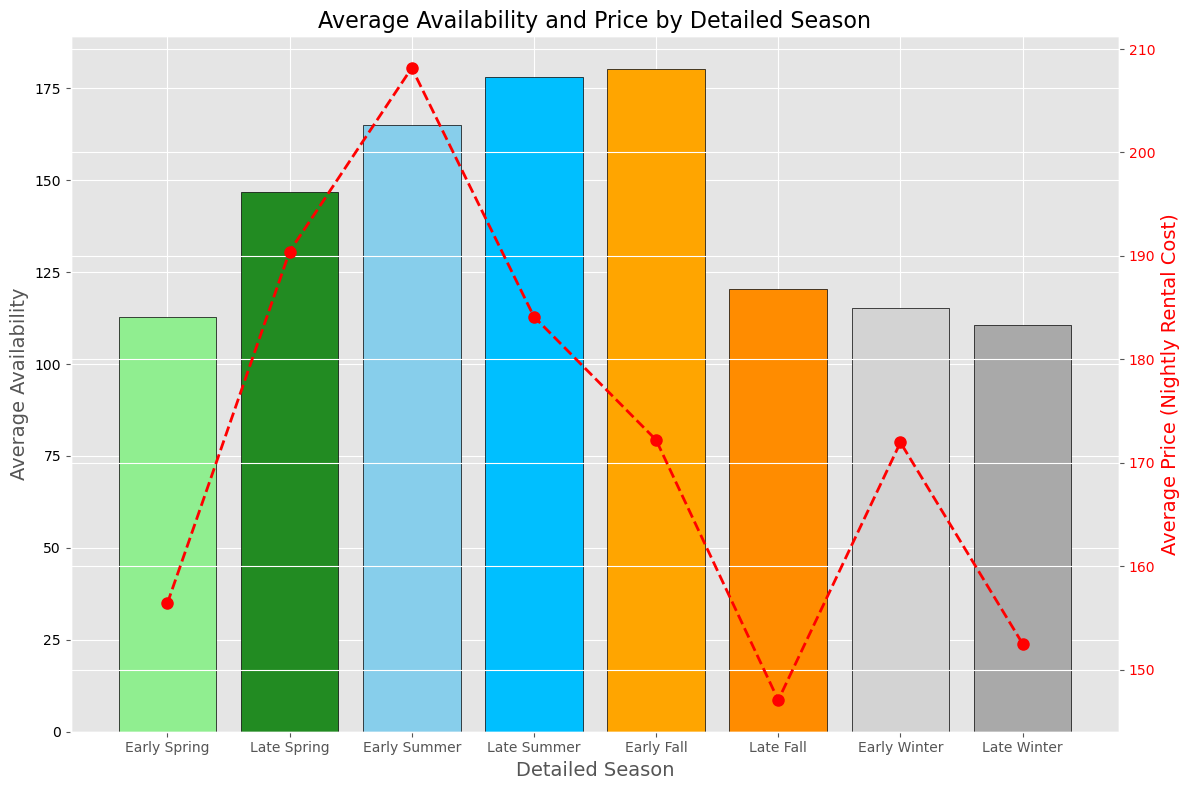

In [7]:
# Plot Average Availability by Detailed Season with Price
plot_seasonal_data(seasonal_data, 'Average Availability', 'Average Availability', 'Average Availability and Price by Detailed Season')